# Loading packages.

In [1]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
import random
import matplotlib.pyplot as plt
import copy

# Loading data.

In [2]:
# Load the wine dataset into a DataFrame
wine_data = load_wine(as_frame=True)
wine_df = wine_data.frame
wine_df = wine_df[wine_df["target"]!=2]
df = pd.DataFrame(wine_df)
y_wine = pd.DataFrame(df["target"])
y_wine = y_wine["target"].replace(0, -1)
y_wine = y_wine.to_numpy()
X_wine = df[['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline']]
X_wine["Bias"] = [1]*130
X_wine = X_wine.to_numpy()

In [3]:
logClassifier = LogisticRegression(random_state=16, max_iter=1000, C=np.inf) # C == infinity makes the regularization go to zero.

# Fit the model with wine data.
logClassifier.fit(X_wine, y_wine)

# Loss*
y_pred_probs_train = logClassifier.predict_proba(X_wine)
training_loss = log_loss(y_wine, y_pred_probs_train)
print("Training loss: ", training_loss)

Training loss:  2.9938022930082024e-06


# Implementing Coordinate Descent.

In [4]:
def initializeWeights(d):
    weights = np.random.randn(d,) * 0.01
    return weights

In [5]:
def log_sigmoid(z):
    if z > 100: return 0
    if z < -100: return -z
    return np.log(1 + np.exp(-z))

In [6]:
def sigmoid(z):
    if z > 100: return 0
    if z < -100: return 1
    return 1/(1 + np.exp(z))

In [7]:
def calcLogLoss(w, X, Y):
    """
    X: n x d dimensions
    w: d x 1 dimensions

    z: n x 1 dimensions
    y: n x 1 dimensions
    """
    Z = np.dot(X, w)
    loss = sum(log_sigmoid(y*z) for z,y in zip(Z,Y))
    loss = loss / X.shape[0]
    return loss           

In [8]:
def calcGradients(w, X, Y):
    """ 
    To calculate dL/dw_j:
        dL/dw_j = sum_i_to_N( (-y_i * x_i_j) / (1 + exp(y_i * (w^T * X_i)))) = sum_i_to_N( A / B )
    """
    gradients = []
    for j in range(X.shape[1]):
        gradient_j = 0
        for i in range(X.shape[0]):
            z = w@X[i,:]
            gradient_j += (-Y[i]*X[i,j])*sigmoid(Y[i]*z)
        gradients.append(gradient_j)
        
    return gradients

In [9]:
def selectI(gradients):
    
    probs = np.abs(gradients) / np.sum(np.abs(gradients))
    
    selected_i = np.random.choice(len(gradients), p=probs)
    
    return selected_i

In [10]:
def updateWofI(w, a, gradients, i):
    """
    print(w_t)
    print(gradients)
    print("===================================")
    print("w(i): ", w_t[i])
    print("Gradient(L(w_i)): ", gradients[i])
    """
    w[i] = w[i] - (a*gradients[i])
    return w

In [11]:
def pickRandomCoordinate(num):
    random_coordinate = random.randint(0,num)
    return random_coordinate

In [12]:
def backtrackingLineSearch(gradients, w, X, Y, i, a=1.0, b=0.5, c=1e-4):
    w_loss = calcLogLoss(w, X, Y)
    
    while True:
        w_new = w.copy()
        w_new = updateWofI(w_new, a, gradients, i)
        loss_new = calcLogLoss(w_new, X, Y)
        
        # Armijo condition: sufficient decrease
        if loss_new <= w_loss - c * a * gradients[i] ** 2:
            break
        a *= b

    return a

In [41]:
def coordinateDescent(weights, X_train, y_train, its, BLS=False, diminishing=False, randomCD=False):
    my_weights = copy.deepcopy(weights)
    
    # Define a list to contain the losses at each iteration
    losses = []
    
    for j in range(its):
        

        # Calculate current loss and add it to the losses list.
        loss = calcLogLoss(w=my_weights, X=X_train, Y=y_train)
        losses.append(loss)
        
        # Calculate partial derivates and select the coordinate with the minimum gradient.
        gradients = calcGradients(w=my_weights, X=X_train, Y=y_train)
        if randomCD:
            index = pickRandomCoordinate(13)
        else:
            index = selectI(gradients=gradients)

        # Step size.
        if BLS:
            a = backtrackingLineSearch(gradients=gradients, w=my_weights, X=X_train, Y=y_train, i=index, a=1.0, b=0.5, c=1e-4)
        elif diminishing:
            # Step size that scales with iteration.
            a = 0.000001/(j+1)
        else:
            # Constant step size
            a = 0.000001
        
        my_weights = updateWofI(w=my_weights, a=a, gradients=gradients, i=index)
        
    return losses

# Plotting Performance.

In [34]:
weights_wine = initializeWeights(14)

# Random i models
randomconstantstep = coordinateDescent(weights=weights_wine, X_train=X_wine, y_train=y_wine, its=50, BLS=False, diminishing=False, randomCD=True)
randomdiminish = coordinateDescent(weights=weights_wine, X_train=X_wine, y_train=y_wine, its=50, BLS=False, diminishing=True, randomCD=True)
randomBLS = coordinateDescent(weights=weights_wine, X_train=X_wine, y_train=y_wine, its=50, BLS=True, diminishing=False, randomCD=True)

# SGP models
SGP = coordinateDescent(weights=weights_wine, X_train=X_wine, y_train=y_wine, its=50, BLS=False, diminishing=False, randomCD=False)
SGPdiminish = coordinateDescent(weights=weights_wine, X_train=X_wine, y_train=y_wine, its=50, BLS=False, diminishing=True, randomCD=False)
SGPBLS = coordinateDescent(weights=weights_wine, X_train=X_wine, y_train=y_wine, its=50, BLS=True, diminishing=False, randomCD=False)

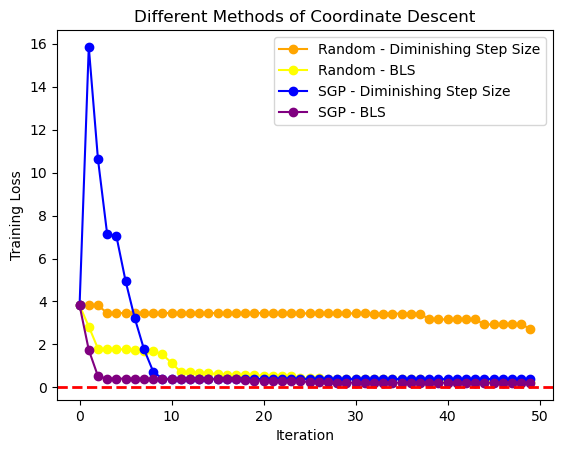

In [36]:
plt.plot(range(50), randomdiminish, marker='o', linestyle='-', color='orange', label='Random - Diminishing Step Size')
plt.plot(range(50), randomBLS, marker='o', linestyle='-', color='yellow', label='Random - BLS')
plt.plot(range(50), SGPdiminish, marker='o', linestyle='-', color='blue', label='SGP - Diminishing Step Size')
plt.plot(range(50), SGPBLS, marker='o', linestyle='-', color='purple', label='SGP - BLS')

plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('Different Methods of Coordinate Descent')
plt.axhline(y=training_loss, color='r', linestyle='--', linewidth=2)
plt.legend()
plt.show()

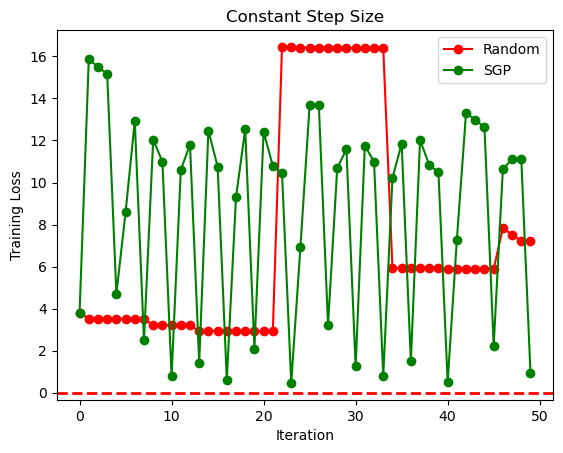

In [43]:
plt.plot(range(50), randomconstantstep, marker='o', linestyle='-', color='red', label='Random')
plt.plot(range(50), SGP, marker='o', linestyle='-', color='green', label='SGP')

plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('Constant Step Size')
plt.axhline(y=training_loss, color='r', linestyle='--', linewidth=2)
plt.legend()
plt.show()